In [0]:
# helper to download the Data Set from Google Drive

import requests
import os

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


In [0]:
# RAVDESS_original.zip https://drive.google.com/open?id=1WyJsDuxJlUObBCFrNZLAXM2w4-sp0CxN
# file_id = '1WyJsDuxJlUObBCFrNZLAXM2w4-sp0CxN'

# RAVDESS_trimmed.zip https://drive.google.com/open?id=1pFum_YGf2C82HJvMwt0gi8apj6PJLi0s
#file_id = '1pFum_YGf2C82HJvMwt0gi8apj6PJLi0s'

# RAVDESS_enriched.zip https://drive.google.com/open?id=1LG42oQTSs6HWMLsdqhFKbADA2wi8234_
# file_id = '1LG42oQTSs6HWMLsdqhFKbADA2wi8234_'

# RAVDESS_spectogram.zip https://drive.google.com/open?id=1jDb2GDnapxx-5bhRR4rudVLxd4ajrpF-
# file_id = '1jDb2GDnapxx-5bhRR4rudVLxd4ajrpF-'

# RAVDESS_train.zip https://drive.google.com/open?id=1a2TRcqj5ySMWwetfU3Zgq4FE-highOKK
file_id = '1a2TRcqj5ySMWwetfU3Zgq4FE-highOKK'

destination = 'RAVDESS.zip'

if not os.path.exists(destination):
    download_file_from_google_drive(file_id, destination)

In [0]:
!ls -lh

total 506M
drwxr-xr-x 3 root root 4.0K Nov 19 11:10 RAVDESS
-rw-r--r-- 1 root root 506M Nov 19 11:10 RAVDESS.zip
drwxr-xr-x 1 root root 4.0K Nov 15 16:31 sample_data


In [0]:
!unzip -n RAVDESS.zip

Archive:  RAVDESS.zip


In [0]:
!ls RAVDESS/train_valid/train -lh

total 1.7M
drwxr-xr-x 2 root root 228K Nov 18 17:33 angry
drwxr-xr-x 2 root root 236K Nov 18 17:33 calm
drwxr-xr-x 2 root root 248K Nov 18 17:33 disgust
drwxr-xr-x 2 root root 208K Nov 18 17:33 fearful
drwxr-xr-x 2 root root 224K Nov 18 17:33 happy
drwxr-xr-x 2 root root  92K Nov 18 17:33 neutral
drwxr-xr-x 2 root root 236K Nov 18 17:33 sad
drwxr-xr-x 2 root root 204K Nov 18 17:33 surprised


In [0]:
import numpy as np
import pandas as pd
import librosa
from scipy.signal import spectrogram
import math
import matplotlib.pyplot as plt
import random
import re
import gc
from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [0]:
def name_to_data(self, path):
    numbers = re.findall(r'\d+', path) # numbers in the name of the audio file
    # spectogram = Image.open(spectogram_path) # consumes too much memory
    return [
        self.emotions[numbers[2]],
        self.emotion_intensities[numbers[3]],
        self.statements[numbers[4]],
        self.repetitions[int(numbers[5])-1],
        numbers[6], 
        self.actors[numbers[6]], 
        path
    ]


# Creates the Data Frame for the RAVDESS
def create_dataframe(self):
    print('Create dataframe')
    data = []
    specograms_paths = self.get_split_image_paths()
    for specograms_path in specograms_paths:
        data.append(self.name_to_data(specograms_path))

    df = pd.DataFrame(  # contruct DataFrame from data
        { 
            'emotion'           : pd.Categorical([row[0] for row in data]),
            'emotion_intensity' : pd.Categorical([row[1] for row in data]),
            'statement'         : pd.Categorical([row[2] for row in data]),
            'repetition'        : pd.Categorical([row[3] for row in data]),
            'actor'             : pd.Categorical([row[4] for row in data]),
            'actor_gender'      : pd.Categorical([row[5] for row in data]),
            'image'             : pd.Categorical([row[6] for row in data])
        })

    # one-hot encode columns
    df = pd.get_dummies(df, columns=["emotion", "emotion_intensity", "statement", "repetition", "actor", "actor_gender"])
    return df

In [0]:
base_dir = 'RAVDESS/train_valid/' # Linux esetén
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
'''train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')'''

"train_cats_dir = os.path.join(train_dir, 'cats')\ntrain_dogs_dir = os.path.join(train_dir, 'dogs')\nvalidation_cats_dir = os.path.join(validation_dir, 'cats')\nvalidation_dogs_dir = os.path.join(validation_dir, 'dogs')"

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input,decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K
import numpy as np

In [0]:
img_height=299
img_width=299

In [0]:
# load the pre-trained InceptionV3 model without the fully-connected layers
base_model = InceptionV3(weights='imagenet', include_top=False)
# az utolsó konvolúciós réteg utána egy global average pooling réteget teszünk, ez rögtön "lapítja" (flatten) a 2D konvolúciót
x = base_model.output
x = GlobalAveragePooling2D()(x)
# ezután hozzáadunk egy előrecsatolt réteget ReLU aktivációs függvénnyel
x = Dense(1024, activation='relu')(x)
# és végül egy kimenete lesz a hálónak - a "binary_crossentropy" költségfüggvénynek erre van szüksége
predictions = Dense(8, activation='softmax')(x)
# a model létrehozása
model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
for layer in base_model.layers:
    layer.trainable = False

# lefordítjuk a modelt (fontos, hogy ezt a rétegek befagyasztása után csináljuk"
# mivel két osztályunk van, ezért bináris keresztentrópia költségfüggvényt használunk
model.compile(optimizer='rmsprop', metrics=['accuracy'],loss='categorical_crossentropy')

In [0]:
# kép felkészítése a betöltésre és adatdúsításra
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=0, width_shift_range=0, height_shift_range=0, horizontal_flip=False, vertical_flip=False)
test_datagen = ImageDataGenerator(rescale=1./255, rotation_range=0, width_shift_range=0, height_shift_range=0, horizontal_flip=False, vertical_flip=False)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=5, class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(img_height, img_width), batch_size=5, class_mode='categorical')

Found 28701 images belonging to 8 classes.
Found 12306 images belonging to 8 classes.


In [0]:
# ez a függvény egyszerre végzi az adatdúsítást és a háló tanítását
model.fit(train_generator,steps_per_epoch=5,validation_data=validation_generator,validation_steps=10,epochs=3)

Epoch 1/3
5/5 [==============================] - 292s 58s/step - loss: 8.8571 - acc: 0.1200 - val_loss: 2.3570 - val_acc: 0.2000
Epoch 2/3
5/5 [==============================] - 287s 57s/step - loss: 3.2538 - acc: 0.1200 - val_loss: 2.1738 - val_acc: 0.1600
Epoch 3/3
5/5 [==============================] - 292s 58s/step - loss: 2.5698 - acc: 0.1600 - val_loss: 2.0449 - val_acc: 0.2200


In [0]:
for layer in model.layers[:172]:
       layer.trainable = False
for layer in model.layers[172:]:
       layer.trainable = True

In [0]:
# ez után újra le kell fordítanunk a hálót, hogy most már az Inception V3 felsőbb rétegei tanuljanak
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), metrics=['accuracy'], loss='categorical_crossentropy')

In [0]:
history = model.fit_generator(train_generator,steps_per_epoch=5,validation_data=validation_generator,validation_steps=10,epochs=3)
print("Tanítás vége.")

Epoch 1/3
5/5 [==============================] - 373s 75s/step - loss: 2.3472 - acc: 0.1200 - val_loss: 2.0289 - val_acc: 0.2200
Epoch 2/3
5/5 [==============================] - 362s 72s/step - loss: 2.2754 - acc: 0.1600 - val_loss: 2.0139 - val_acc: 0.2200
Epoch 3/3
5/5 [==============================] - 362s 72s/step - loss: 2.1137 - acc: 0.1200 - val_loss: 2.0033 - val_acc: 0.2200
Tanítás vége.


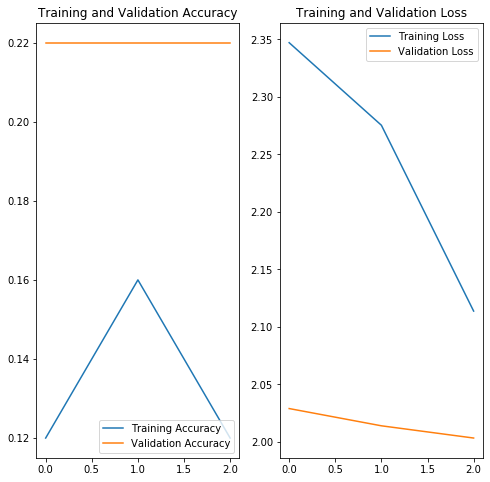

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(3)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
print(history.history)

{'loss': [2.347193384170532, 2.275360107421875, 2.1136982679367065], 'acc': [0.12, 0.16, 0.12], 'val_loss': [2.0288960099220277, 2.013890266418457, 2.0032501339912416], 'val_acc': [0.22, 0.22, 0.22]}
